# Mask-Dino Demo Tutorials

### Import Library

In [1]:
import argparse
import glob
import multiprocessing as mp
import os
import warnings
warnings.filterwarnings("ignore")

# fmt: off
import sys
home_dir = os.path.abspath(os.getcwd()+"/../")
sys.path.insert(1, home_dir)
print(home_dir)

# fmt: on
import tempfile
import time
import warnings

import cv2
import numpy as np
import tqdm

from matplotlib import pyplot as plt

from detectron2.config import get_cfg
from detectron2.data.detection_utils import read_image
from detectron2.projects.deeplab import add_deeplab_config
# from detectron2.utils.logger import setup_logger

from maskdino import add_maskdino_config
from predictor import VisualizationDemo

/home/djjin/Mygit/MaskDINO


In [2]:
WINDOW_NAME = "mask2former demo"

def setup_cfg(args):
    # load config from file and command-line arguments
    cfg = get_cfg()
    add_deeplab_config(cfg)
    add_maskdino_config(cfg)
    cfg.merge_from_file(args.config_file)
    cfg.merge_from_list(args.opts)
    cfg.freeze()
    return cfg

def get_parser():
    parser = argparse.ArgumentParser(description="maskdino demo for builtin configs")
    parser.add_argument(
        "--config-file",
        default="../configs/coco/instance-segmentation/maskdino_R50_bs16_50ep_3s.yaml",
        metavar="FILE",
        help="path to config file",
    )
    parser.add_argument("--webcam", action="store_true", help="Take inputs from webcam.")
    parser.add_argument("--video-input", help="Path to video file.")
    parser.add_argument(
        "--input",
        nargs="+",
        help="A list of space separated input images; "
        "or a single glob pattern such as 'directory/*.jpg'",
    )
    parser.add_argument(
        "--output",
        help="A file or directory to save output visualizations. "
        "If not given, will show output in an OpenCV window.",
    )

    parser.add_argument(
        "--confidence-threshold",
        type=float,
        default=0.5,
        help="Minimum score for instance predictions to be shown",
    )
    parser.add_argument(
        "--opts",
        help="Modify config options using the command-line 'KEY VALUE' pairs",
        default=[],
        nargs=argparse.REMAINDER,
    )
    return parser

In [3]:
mp.set_start_method("spawn", force=True)
args = get_parser().parse_args('')

# setup_logger(name="fvcore")
# logger = setup_logger()
# logger.info("Arguments: " + str(args))

args.input = ["../images/london.jpg"]
args.opts = ['MODEL.WEIGHTS', '../ckpts/maskdino_r50_50ep_300q_hid1024_3sd1_instance_maskenhanced_mask46.1ap_box51.5ap.pth']
args.output = home_dir + "/outputs"

In [4]:
cfg = setup_cfg(args)
demo = VisualizationDemo(cfg)

criterion.weight_dict  {'loss_ce': 4.0, 'loss_mask': 5.0, 'loss_dice': 5.0, 'loss_bbox': 5.0, 'loss_giou': 2.0, 'loss_ce_interm': 4.0, 'loss_mask_interm': 5.0, 'loss_dice_interm': 5.0, 'loss_bbox_interm': 5.0, 'loss_giou_interm': 2.0, 'loss_ce_dn': 4.0, 'loss_mask_dn': 5.0, 'loss_dice_dn': 5.0, 'loss_bbox_dn': 5.0, 'loss_giou_dn': 2.0, 'loss_ce_interm_dn': 4.0, 'loss_mask_interm_dn': 5.0, 'loss_dice_interm_dn': 5.0, 'loss_bbox_interm_dn': 5.0, 'loss_giou_interm_dn': 2.0, 'loss_ce_0': 4.0, 'loss_mask_0': 5.0, 'loss_dice_0': 5.0, 'loss_bbox_0': 5.0, 'loss_giou_0': 2.0, 'loss_ce_interm_0': 4.0, 'loss_mask_interm_0': 5.0, 'loss_dice_interm_0': 5.0, 'loss_bbox_interm_0': 5.0, 'loss_giou_interm_0': 2.0, 'loss_ce_dn_0': 4.0, 'loss_mask_dn_0': 5.0, 'loss_dice_dn_0': 5.0, 'loss_bbox_dn_0': 5.0, 'loss_giou_dn_0': 2.0, 'loss_ce_interm_dn_0': 4.0, 'loss_mask_interm_dn_0': 5.0, 'loss_dice_interm_dn_0': 5.0, 'loss_bbox_interm_dn_0': 5.0, 'loss_giou_interm_dn_0': 2.0, 'loss_ce_1': 4.0, 'loss_mask_1':

### Image Demo

../images/london.jpg: detected 100 instances in 3.27s


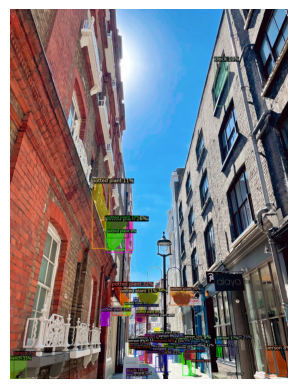

In [5]:
for path in tqdm.tqdm(args.input, disable=True):
    # use PIL, to be consistent with evaluation
    img = read_image(path, format="BGR")
    start_time = time.time()
    predictions, visualized_output = demo.run_on_image(img)
    print(
        "{}: {} in {:.2f}s".format(
            path,
            "detected {} instances".format(len(predictions["instances"]))
            if "instances" in predictions
            else "finished",
            time.time() - start_time,
        )
    )
    plt.axis('off')
    plt.imshow(visualized_output.get_image()[:, :, :])
    plt.show()

    if os.path.isdir(args.output):
        assert os.path.isdir(args.output), args.output
        out_filename = os.path.join(args.output, os.path.basename(path))
    else:
        assert len(args.input) == 1, "Please specify a directory with args.output"
        out_filename = args.output
    visualized_output.save(out_filename)


### Webcam Demo

In [6]:
cam = cv2.VideoCapture(0)
for vis in tqdm.tqdm(demo.run_on_video(cam)):
    cv2.namedWindow(WINDOW_NAME, cv2.WINDOW_NORMAL)
    cv2.imshow(WINDOW_NAME, vis)
    if cv2.waitKey(1) == 27:
        break  # esc to quit
cam.release()
cv2.destroyAllWindows()

3it [00:02,  1.14it/s]


### Video Demo

In [7]:
args.video_input = '../videos/planning.mp4'

video = cv2.VideoCapture(args.video_input)
num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
basename = os.path.basename(args.video_input)

for vis_frame in tqdm.tqdm(demo.run_on_video(video), total=num_frames):
    cv2.namedWindow(basename, cv2.WINDOW_NORMAL)
    cv2.imshow(basename, vis_frame)
    if cv2.waitKey(1) == 27:
        break  # esc to quit

video.release()
cv2.destroyAllWindows()

  0%|          | 2/1110 [00:09<1:26:43,  4.70s/it]
